In [16]:
import geopandas as gpd
import pandas as pd

import mapillary as mly

import glob

from datetime import datetime


import gzip
import os
import json



### osm-netzwerk einlesen

In [2]:
#set_date = "251010" 
#set_date = "251022" 
#set_date = "251215" 
set_date = "260109" 


cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
#motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

print("number of cycleways:", len(cycleways))
#print("number of motorways:", len(motorways))

number of cycleways: 5528732


In [3]:
#cycleways.head()

In [4]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [5]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated","yes"])) |
    (cycleways["bicycle_backward"].isin(["designated","yes"])) |
    (cycleways["bicycle_forward"].isin(["designated","yes"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk_bicycle"].isin(["designated"])) |  TODO: add "sidewalk:bicycle" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated","yes"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated","yes"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated","yes"])) 
]
len(filtered_cycleways)

1391519

In [6]:
#filtered_cycleways[::10].plot()

In [7]:
# # Lade lk
# lk = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/4_kreise/1_sehr_hoch.geo.json")
# #lk[lk.NAME_3 == "Ravensburg"].plot()

# sel_lk = lk[lk.NAME_3 == "Berlin"]
# sel_lk=sel_lk.to_crs(filtered_cycleways.crs)
# filtered_cycleways_lk = filtered_cycleways.clip(sel_lk)

# filtered_cycleways_lk.plot()

In [8]:
#motorways.plot()

In [9]:
filtered_cycleways_proj = filtered_cycleways.to_crs(25833)
filtered_cycleways_proj["length_m"] = filtered_cycleways_proj.geometry.length
#filtered_cycleways_proj[["osm_id", "length_m"]]

total_km = filtered_cycleways_proj.length_m.sum() / 1000
print(f"Gesamtlänge der gefilterten 'Radinfra': {total_km:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") + " km")

Gesamtlänge der gefilterten 'Radinfra': 279.113,38 km


In [10]:
#filtered_cycleways.highway.value_counts()

### mapillary features einlesen

In [15]:


## Points
# https://www.mapillary.com/developer/api-documentation/points?locale=de_DE


### EINLESEN

# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/mapillary_map-feature-points*.parquet")



# --- 2b) Read dataset metadata (instead of parsing dates from filenames) ---
metadata_path = os.path.join("..", "..", "output", "ml-mf_metadata.json")
ml_mf_metadata = None
ml_data_from = None
processed_date = None
bundeslaender_meta = {}

if os.path.exists(metadata_path):
    with open(metadata_path, "r", encoding="utf-8") as f:
        ml_mf_metadata = json.load(f)
    ml_data_from = ml_mf_metadata.get("ml_data_from")
    processed_date = ml_mf_metadata.get("processed_date")
    bundeslaender_meta = ml_mf_metadata.get("bundeslaender", {})
    print("✅ Loaded metadata:", metadata_path)
    print("  ml_data_from:", ml_data_from)
    print("  processed_date:", processed_date)
    print("  bundeslaender:", len(bundeslaender_meta))
else:
    print("⚠️ Metadata not found:", metadata_path)

# Keep a `dates` variable for backwards compatibility with later cells
dates = [d for d in [ml_data_from, processed_date] if d]





# Read all files and concatenate into one GeoDataFrame
mapillary_mf_points = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)




### FILTERN
cw_marking="marking--discrete--symbol--bicycle"



# filter to cw only
mapillary_mf_points_cw=mapillary_mf_points[mapillary_mf_points.value.isin([cw_marking])]
# drop duplicates if any
mapillary_mf_points_cw=mapillary_mf_points_cw.drop_duplicates(subset=['id'])

mapillary_mf_points_cw


# 2025-11-15 ## -> 123991  features




✅ Loaded metadata: ../../output/ml-mf_metadata.json
  ml_data_from: 2026-01-03T16:17:44.025499+00:00
  processed_date: 2026-01-03T21:19:40.795942+00:00
  bundeslaender: 16


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
2686,POINT (11.17118 50.35908),2017-11-08,816806049005151,2017-11-08,marking--discrete--symbol--bicycle,8700,5531
7821,POINT (11.79512 50.42734),2021-12-24,160558686891178,2021-12-24,marking--discrete--symbol--bicycle,8728,5526
9213,POINT (9.94891 50.76371),2025-08-14,746929844714535,2025-08-14,marking--discrete--symbol--bicycle,8644,5502
10897,POINT (10.03799 50.83823),2025-08-14,1047571853857122,2025-08-14,marking--discrete--symbol--bicycle,8648,5496
12842,POINT (10.0852 50.84185),2025-08-14,1830878970800875,2025-08-14,marking--discrete--symbol--bicycle,8650,5496
...,...,...,...,...,...,...,...
36131769,POINT (13.46985 48.57533),2020-08-11,499706968025043,2020-08-11,marking--discrete--symbol--bicycle,8805,5655
36133149,POINT (13.49661 48.57809),2020-08-12,306179717882063,2020-08-12,marking--discrete--symbol--bicycle,8806,5655
36133178,POINT (13.49362 48.57639),2020-08-12,269413614934323,2020-08-12,marking--discrete--symbol--bicycle,8806,5655
36138779,POINT (13.72527 48.51202),2020-08-12,1457994291206350,2020-08-12,marking--discrete--symbol--bicycle,8816,5660


In [17]:

### cehck if really inside germany


gz_path = "../utils/OSMB-germany.geojson.gz"

# Try GDAL's virtual filesystem (/vsigzip) via pyogrio engine first
try:
    germany_boundary = gpd.read_file(f"/vsigzip/{gz_path}", engine="pyogrio")
except Exception:
    # Fallback: manual gzip decompress + GeoJSON parse
    with gzip.open(gz_path, "rt", encoding="utf-8") as f:
        geojson_obj = json.load(f)
    germany_boundary = gpd.GeoDataFrame.from_features(geojson_obj, crs="EPSG:4326")

In [20]:
# Clip traffic signs to Germany boundary

mapillary_mf_points_cw = gpd.sjoin(
    mapillary_mf_points_cw, 
    germany_boundary[['geometry']], 
    predicate='within', 
    how='inner'
)
mapillary_mf_points_cw = mapillary_mf_points_cw.drop(columns=['index_right'])

print(f"Markings after clipping to Germany: {len(mapillary_mf_points_cw)}")

Markings after clipping to Germany: 128671


<Axes: xlabel='last_seen_at'>

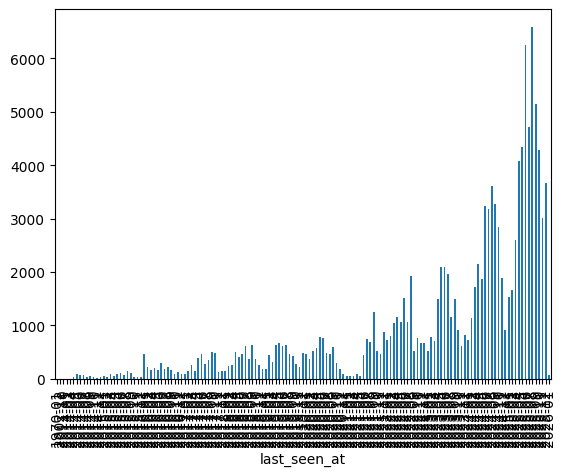

In [21]:
mapillary_mf_points_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


#### Zeitfilter 

In [22]:
##  is newer than 2025-01-01  

# november  2025: 42243


mapillary_mf_points_cw=mapillary_mf_points_cw[mapillary_mf_points_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent
len(mapillary_mf_points_cw)

47934

In [23]:
mapillary_mf_points_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
9213,POINT (9.94891 50.76371),2025-08-14,746929844714535,2025-08-14,marking--discrete--symbol--bicycle,8644,5502
10897,POINT (10.03799 50.83823),2025-08-14,1047571853857122,2025-08-14,marking--discrete--symbol--bicycle,8648,5496
12842,POINT (10.0852 50.84185),2025-08-14,1830878970800875,2025-08-14,marking--discrete--symbol--bicycle,8650,5496
13550,POINT (10.10429 51.01045),2025-10-02,856126983418938,2025-10-02,marking--discrete--symbol--bicycle,8651,5484
24814,POINT (11.66662 51.10518),2025-06-07,729623532853215,2025-06-07,marking--discrete--symbol--bicycle,8722,5477
...,...,...,...,...,...,...,...
36129341,POINT (13.47836 48.57113),2025-08-31,1325770248915416,2025-08-31,marking--discrete--symbol--bicycle,8805,5656
36130672,POINT (13.47024 48.57521),2025-09-08,1254931159738833,2025-09-08,marking--discrete--symbol--bicycle,8805,5655
36130685,POINT (13.46966 48.57529),2020-06-04,493922665281090,2025-09-08,marking--discrete--symbol--bicycle,8805,5655
36130728,POINT (13.47309 48.57731),2025-09-07,4636844509875726,2025-09-07,marking--discrete--symbol--bicycle,8805,5655


<Axes: xlabel='last_seen_at'>

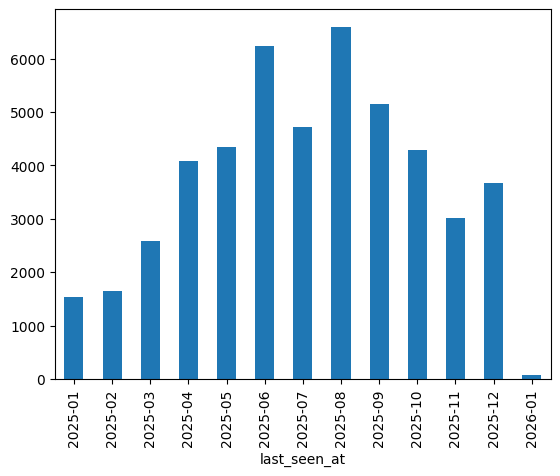

In [24]:
mapillary_mf_points_cw.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")


In [25]:
##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this


zeitspanne = 9

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_mf_points_cw_temp = mapillary_mf_points_cw[
    mapillary_mf_points_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= zeitspanne, axis=1)
]
len(mapillary_mf_points_cw_temp)

14920

<Axes: xlabel='last_seen_at'>

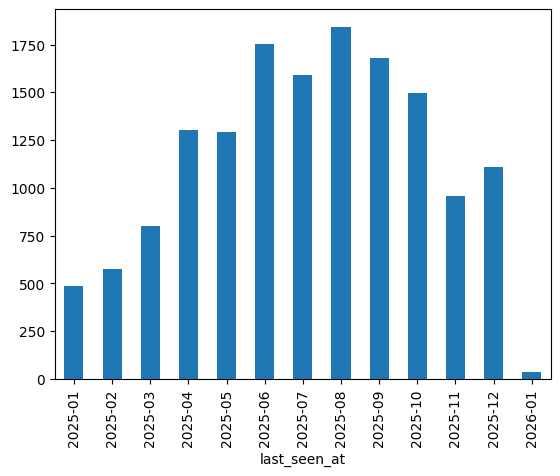

In [26]:
mapillary_mf_points_cw_temp.last_seen_at.str[:-3].value_counts().sort_index().plot(kind="bar")



<Axes: >

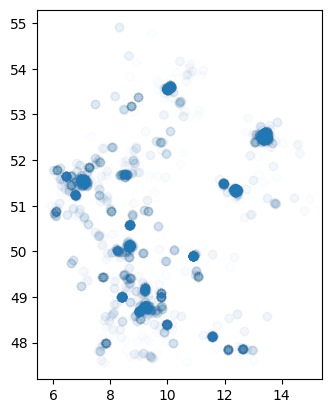

In [27]:
mapillary_mf_points_cw_temp.plot(alpha=0.01)

#### Räumliche Prüfung 

In [28]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered_30 = mapillary_mf_points_cw_temp.to_crs(25833).copy()
df_buffered_25 = mapillary_mf_points_cw_temp.to_crs(25833).copy()

#df_buffered["geometry"] = df_buffered.geometry.buffer(50)
#df_buffered["geometry"] = df_buffered.geometry.buffer(40)
df_buffered_30["geometry"] = df_buffered_30.geometry.buffer(30)
df_buffered_25["geometry"] = df_buffered_25.geometry.buffer(25)


df_buffered_30 = df_buffered_30.to_crs(mapillary_mf_points_cw_temp.crs)
df_buffered_25 = df_buffered_25.to_crs(mapillary_mf_points_cw_temp.crs)


In [29]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [30]:
# For cycleways
df_buffered_30 = mark_intersections(df_buffered_30, filtered_cycleways, column_name="has_cw_intersection")
df_buffered_25 = mark_intersections(df_buffered_25, filtered_cycleways, column_name="has_cw_intersection")



# For motorways (just 30m for both)
#df_buffered_30 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")
#df_buffered_20 = mark_intersections(df_buffered_30, motorways, column_name="has_mw_intersection")



In [31]:
df_buffered_30["buffer_size"] = 30
df_buffered_25["buffer_size"] = 25

In [32]:
#df_buffered.id.unique()

In [33]:
# An wie vielen Schilder ist ein Radweg in der Nähe?
df_buffered_30.has_cw_intersection.value_counts()

has_cw_intersection
True     14506
False      414
Name: count, dtype: int64

In [34]:
df_buffered_25.has_cw_intersection.value_counts()

has_cw_intersection
True     14462
False      458
Name: count, dtype: int64

In [35]:
# An wie vielen Schilder ist eine Autobahn in der Nähe?
#df_buffered_30.has_mw_intersection.value_counts()

In [36]:
#df_buffered_30.has_mw_intersection

In [37]:
#df_buffered_25_false=df_buffered_25[(df_buffered_25.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
df_buffered_25_false=df_buffered_25[(df_buffered_25.has_cw_intersection== False)].copy()

len(df_buffered_25_false)

458

In [38]:
#df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False) & (df_buffered_30.has_mw_intersection== False)].copy()
df_buffered_30_false=df_buffered_30[(df_buffered_30.has_cw_intersection== False)].copy()

len(df_buffered_30_false)

414

In [39]:
df_buffered_25_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size
1103836,"POLYGON ((9.9926 53.55347, 9.9926 53.55345, 9....",2018-06-27,820475078584063,2025-06-21,marking--discrete--symbol--bicycle,8646,5294,False,25
1103850,"POLYGON ((9.99206 53.55383, 9.99206 53.55381, ...",2022-03-05,146623197823537,2025-06-21,marking--discrete--symbol--bicycle,8646,5294,False,25
1122910,"POLYGON ((9.99239 53.5494, 9.99239 53.54938, 9...",2018-06-10,167123581927369,2025-06-21,marking--discrete--symbol--bicycle,8646,5295,False,25
1186781,"POLYGON ((10.0058 53.55609, 10.0058 53.55607, ...",2023-04-17,791076118765573,2025-06-21,marking--discrete--symbol--bicycle,8647,5294,False,25
1339151,"POLYGON ((10.0729 53.59635, 10.0729 53.59633, ...",2024-04-06,342111891671339,2025-05-01,marking--discrete--symbol--bicycle,8650,5291,False,25
...,...,...,...,...,...,...,...,...,...
35939015,"POLYGON ((12.9773 47.83229, 12.9773 47.83227, ...",2024-09-19,545502615014897,2025-11-07,marking--discrete--symbol--bicycle,8782,5706,False,25
35939023,"POLYGON ((12.97705 47.83184, 12.97705 47.83182...",2024-10-08,1967148217088123,2025-11-07,marking--discrete--symbol--bicycle,8782,5706,False,25
35939034,"POLYGON ((12.97687 47.83143, 12.97687 47.83141...",2024-09-19,924599445858616,2025-11-07,marking--discrete--symbol--bicycle,8782,5706,False,25
35988346,"POLYGON ((13.00136 47.62704, 13.00136 47.62702...",2022-03-19,375506571092325,2025-08-09,marking--discrete--symbol--bicycle,8783,5720,False,25


In [40]:
df_buffered_both_false= pd.concat([df_buffered_30_false, df_buffered_25_false]).sort_values("buffer_size").drop_duplicates(subset=['id'],keep="last")
df_buffered_both_false["buffer_size"].value_counts()

buffer_size
30    414
25     44
Name: count, dtype: int64

priority bei MapRoulette:

| Wert | Bedeutung         |
| ---- | ----------------- |
| 0    | High              |
| 1    | Medium (Standard) |
| 2    | Low               |


In [41]:
df_buffered_both_false["prio"] = df_buffered_both_false["buffer_size"].map({25: 1, 30: 0}).astype("Int64")

In [42]:
df_buffered_both_false

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size,prio
1343356,"POLYGON ((10.07916 53.5895, 10.07916 53.58948,...",2023-11-22,374376852101107,2025-06-26,marking--discrete--symbol--bicycle,8650,5292,False,25,1
34729942,"POLYGON ((12.1233 47.85656, 12.1233 47.85654, ...",2024-04-13,1847143382435065,2025-10-25,marking--discrete--symbol--bicycle,8743,5705,False,25,1
19643494,"POLYGON ((13.38761 52.52693, 13.38761 52.52691...",2019-10-05,165602328840306,2025-07-11,marking--discrete--symbol--bicycle,8801,5372,False,25,1
24441675,"POLYGON ((6.88497 51.42792, 6.88498 51.4279, 6...",2023-03-04,147603964845436,2025-06-10,marking--discrete--symbol--bicycle,8505,5453,False,25,1
24443299,"POLYGON ((6.89605 51.42906, 6.89605 51.42904, ...",2023-03-04,3024070084564220,2025-05-21,marking--discrete--symbol--bicycle,8505,5453,False,25,1
...,...,...,...,...,...,...,...,...,...,...
6613010,"POLYGON ((8.66623 49.4401, 8.66623 49.44007, 8...",2024-09-25,1391121241989247,2025-10-18,marking--discrete--symbol--bicycle,8586,5595,False,30,0
5839949,"POLYGON ((8.38994 49.00755, 8.38995 49.00752, ...",2024-03-25,726053583012135,2025-02-19,marking--discrete--symbol--bicycle,8573,5626,False,30,0
1515614,"POLYGON ((10.15011 53.59555, 10.15011 53.59553...",2022-06-03,707017497037575,2025-03-08,marking--discrete--symbol--bicycle,8653,5291,False,30,0
1515591,"POLYGON ((10.14921 53.59546, 10.14921 53.59544...",2022-06-03,1176890833109602,2025-03-08,marking--discrete--symbol--bicycle,8653,5291,False,30,0


In [43]:
# interactive map
# df_buffered_false.explore(
#     color="red",
#     tiles="CartoDB positron",
#     popup=True,
#     tooltip=["value", "first_seen_at", "last_seen_at"]
# )

In [44]:
import json
import requests

#### clean up from existing maproulette challenge

In [45]:
### import the the flagged (not created, fixed) tasks from the challenge. 

# challenge_gdf = gpd.read_file("challenge_53882_data_f_mr.geojson")
#challenge_gdf.head()

with open("../utils/config_mapillary_privat.json", "r") as f:
    config = json.load(f)
API_KEY = config["API_KEY_MAPROULETTE"]

CHALLENGE_ID = 53882
BASE_URL = "https://maproulette.org/api/v2"

headers = {"apiKey": API_KEY}

# Single request to get all tasks as GeoJSON
r = requests.get(
    f"{BASE_URL}/challenge/view/{CHALLENGE_ID}",
    headers=headers
)
r.raise_for_status()
geojson_data = r.json()

# Convert directly to GeoDataFrame
challenge_gdf = gpd.GeoDataFrame.from_features(geojson_data, crs='EPSG:4326')

challenge_gdf=challenge_gdf[~challenge_gdf.mr_taskStatus.isin(["Fixed", "Created", "Skipped"])]

df_buffered_both_false = df_buffered_both_false.to_crs(4326)

# Find intersections
intersections = gpd.sjoin(df_buffered_both_false, challenge_gdf, how="left", predicate="intersects")

# Keep only rows that do NOT intersect (i.e., no match in challenge_gdf)
df_buffered_both_false_no_challenge = df_buffered_both_false.loc[intersections.index[intersections["index_right"].isna()]] 

len(df_buffered_both_false_no_challenge)


430

### retrieve the image ID for the map features

In [46]:
df_process_img= df_buffered_both_false.copy()
#df_process_img= df_buffered_both_false_no_challenge.copy()

In [47]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------------------------------------------------------------


# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("../utils/config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_process_img["image_id"] = parallel_get_image_ids(df_process_img["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 458/458 [01:29<00:00,  5.12it/s]


In [48]:
## https://www.mapillary.com/app/?pKey=1029316554880692

df_process_img.head()



,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size,prio,image_id
1343356,"POLYGON ((10.07916 53.5895, 10.07916 53.58948,...",2023-11-22,374376852101107,2025-06-26,marking--discrete--symbol--bicycle,8650,5292,False,25,1,971456827731985
34729942,"POLYGON ((12.1233 47.85656, 12.1233 47.85654, ...",2024-04-13,1847143382435065,2025-10-25,marking--discrete--symbol--bicycle,8743,5705,False,25,1,1803546520153312
19643494,"POLYGON ((13.38761 52.52693, 13.38761 52.52691...",2019-10-05,165602328840306,2025-07-11,marking--discrete--symbol--bicycle,8801,5372,False,25,1,193711429239570
24441675,"POLYGON ((6.88497 51.42792, 6.88498 51.4279, 6...",2023-03-04,147603964845436,2025-06-10,marking--discrete--symbol--bicycle,8505,5453,False,25,1,196889562959160
24443299,"POLYGON ((6.89605 51.42906, 6.89605 51.42904, ...",2023-03-04,3024070084564220,2025-05-21,marking--discrete--symbol--bicycle,8505,5453,False,25,1,2353109918186268


In [49]:
# to points, to 4326

centroids = df_process_img.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids.sort_values("last_seen_at")


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size,prio,image_id
14462290,POINT (8.6921 50.14658),2019-01-03,515433849821306,2025-01-04,marking--discrete--symbol--bicycle,8587,5546,False,30,0,680805196025809
19929521,POINT (13.40599 52.53492),2016-01-31,104995745887981,2025-01-04,marking--discrete--symbol--bicycle,8802,5372,False,30,0,915283566393502
19777000,POINT (13.40338 52.60274),2022-12-30,566851194886207,2025-01-12,marking--discrete--symbol--bicycle,8802,5367,False,30,0,1558834601228721
19776990,POINT (13.40373 52.60267),2022-12-30,566851184886208,2025-01-12,marking--discrete--symbol--bicycle,8802,5367,False,30,0,855517302220319
19929430,POINT (13.40492 52.53374),2019-05-12,287311776456271,2025-01-13,marking--discrete--symbol--bicycle,8802,5372,False,30,0,772300566803690
...,...,...,...,...,...,...,...,...,...,...,...
15275384,POINT (9.17939 50.90999),2025-03-09,982524740183397,2026-01-01,marking--discrete--symbol--bicycle,8609,5491,False,30,0,693149010031427
15275398,POINT (9.1802 50.91043),2025-03-09,3985041538412334,2026-01-01,marking--discrete--symbol--bicycle,8609,5491,False,30,0,1016532413712039
15275296,POINT (9.17661 50.90885),2025-03-09,629457326367881,2026-01-01,marking--discrete--symbol--bicycle,8609,5491,False,30,0,1002064698032457
15275304,POINT (9.17702 50.90887),2025-03-09,629457329701214,2026-01-01,marking--discrete--symbol--bicycle,8609,5491,False,30,0,2394930244179919


In [50]:
# Mapping dictionary
value_to_vz = {
    'marking--discrete--symbol--bicycle': 'Lane marking - symbol (bicycle)',
}


# Add new column based on mapping
centroids["MapFeaturePoint"] = centroids["value"].map(value_to_vz)

In [51]:
#centroids

In [52]:
centroids

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,buffer_size,prio,image_id,MapFeaturePoint
1343356,POINT (10.07879 53.58949),2023-11-22,374376852101107,2025-06-26,marking--discrete--symbol--bicycle,8650,5292,False,25,1,971456827731985,Lane marking - symbol (bicycle)
34729942,POINT (12.12296 47.85655),2024-04-13,1847143382435065,2025-10-25,marking--discrete--symbol--bicycle,8743,5705,False,25,1,1803546520153312,Lane marking - symbol (bicycle)
19643494,POINT (13.38724 52.52693),2019-10-05,165602328840306,2025-07-11,marking--discrete--symbol--bicycle,8801,5372,False,25,1,193711429239570,Lane marking - symbol (bicycle)
24441675,POINT (6.88462 51.4279),2023-03-04,147603964845436,2025-06-10,marking--discrete--symbol--bicycle,8505,5453,False,25,1,196889562959160,Lane marking - symbol (bicycle)
24443299,POINT (6.8957 51.42904),2023-03-04,3024070084564220,2025-05-21,marking--discrete--symbol--bicycle,8505,5453,False,25,1,2353109918186268,Lane marking - symbol (bicycle)
...,...,...,...,...,...,...,...,...,...,...,...,...
6613010,POINT (8.66581 49.44008),2024-09-25,1391121241989247,2025-10-18,marking--discrete--symbol--bicycle,8586,5595,False,30,0,1064485845850645,Lane marking - symbol (bicycle)
5839949,POINT (8.38954 49.00752),2024-03-25,726053583012135,2025-02-19,marking--discrete--symbol--bicycle,8573,5626,False,30,0,1573784190063672,Lane marking - symbol (bicycle)
1515614,POINT (10.14966 53.59554),2022-06-03,707017497037575,2025-03-08,marking--discrete--symbol--bicycle,8653,5291,False,30,0,3981279695431559,Lane marking - symbol (bicycle)
1515591,POINT (10.14875 53.59545),2022-06-03,1176890833109602,2025-03-08,marking--discrete--symbol--bicycle,8653,5291,False,30,0,1057949711765905,Lane marking - symbol (bicycle)


In [53]:
centroids["prio_text"] = centroids["prio"].map({
    0: "🟩 Task mit hoher Wahrscheinlichkeit valide",
    1: "🟨 Task mit mittlerer Wahrscheinlichkeit valide",
    2: "🟥 Task mit eher geringer Wahrscheinlichkeit valide"
})

centroids[["prio", "prio_text"]].head()

,prio,prio_text
1343356,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
34729942,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
19643494,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
24441675,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide
24443299,1,🟨 Task mit mittlerer Wahrscheinlichkeit valide


In [54]:
#centroids.plot()

In [55]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&mapFeature[]=marking--discrete--symbol--bicycle"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2&data=mapillary-cycleway-traffic-signs"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Erkanntes Fahrrad-Symbol überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Map Feature an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst. Die nächste OSM-Radinfra ist mind. **{row["buffer_size"]} Meter** entfernt.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Die neueste Aufnahme hier ist von **{row["last_seen_at"]})**, die älteste ist von **{row["first_seen_at"]}**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- OSM-Wiki: Radinfra auf der Fahrbahn (Übersicht)  
    https://wiki.openstreetmap.org/wiki/Template:DE:Map_Features:cycleway
- OSM-Wiki: Radverkehrsanlagen kartieren  
    https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren
---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": image_id,
            #"Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction,   #.strip(),
            "priority":  row["prio"],
            "name": row["prio_text"]
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id":  str(row[id_field]), # detection Id
           # "priority":  row["prio"] 
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [56]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_markings.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radinfrastuktur anhand von Mapillary-Map feature ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Fahrrad-Symbolen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Fahrrad-Symbol wurde **in Mapillary erkannt**.
- Das Fahrrad-Symbol wurde **mindestens 9 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 30 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''